# MASE Time-Series DataLoader Test
Tests the `TimeSeriesBaseDataset` / `get_timeseries_dataset` infrastructure against `autogluon/chronos_datasets` on HuggingFace.

## 1. Import Required Libraries

In [1]:
import sys, time
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

if os.name == 'nt' and 'HOME' not in os.environ:
    os.environ['HOME'] = os.path.expanduser("~")

# Make sure the MASE src directory is on the path when running from chronos2/
sys.path.insert(0, "../src")

from chop.dataset.timeseries import get_timeseries_dataset, TIMESERIES_DATASET_MAPPING

print("Available timeseries datasets:", list(TIMESERIES_DATASET_MAPPING.keys()))

c:\Users\User\Documents\Coding\mase\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
c:\Users\User\Documents\Coding\mase\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available timeseries datasets: ['chronos_m4_daily', 'chronos_m4_weekly', 'chronos_m4_monthly']


## 2. Configure Data Loader Parameters

In [2]:
# --- Dataset choice ---
DATASET_NAME     = "chronos_m4_daily"   # change to any key in TIMESERIES_DATASET_MAPPING
CONTEXT_LENGTH   = 512                  # past timesteps fed to the model
PREDICTION_LENGTH = 14                  # future timesteps to predict (M4 daily standard)
STRIDE           = 1                    # window step (1 = fully overlapping)

# --- DataLoader ---
BATCH_SIZE   = 32
NUM_WORKERS  = 0   # set >0 on Linux; keep 0 on Windows to avoid spawn issues

print(f"Dataset      : {DATASET_NAME}")
print(f"Context      : {CONTEXT_LENGTH}  Prediction : {PREDICTION_LENGTH}  Stride : {STRIDE}")
print(f"Batch size   : {BATCH_SIZE}       Workers    : {NUM_WORKERS}")

Dataset      : chronos_m4_daily
Context      : 512  Prediction : 14  Stride : 1
Batch size   : 32       Workers    : 0


## 3. Load Sample Dataset

In [3]:
train_ds = get_timeseries_dataset(
    DATASET_NAME,
    split="train",
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    stride=STRIDE,
    auto_setup=True,
)

print(f"Train dataset : {train_ds}")
print()

# Peek at the first window
sample = train_ds[0]
print("Keys in sample     :", list(sample.keys()))
print("past_values  shape :", sample["past_values"].shape)
print("future_values shape:", sample["future_values"].shape)
print("past_values  dtype :", sample["past_values"].dtype)
print()
print("First 10 past values  :", sample["past_values"][:10].numpy())
print("All future values     :", sample["future_values"].numpy())

Train dataset : ChronosM4DailyDataset(split='train', n_series=4227, n_windows=8121644, context=512, pred=14)

Keys in sample     : ['past_values', 'future_values']
past_values  shape : torch.Size([512])
future_values shape: torch.Size([14])
past_values  dtype : torch.float32

First 10 past values  : [1017.1 1019.3 1017.  1019.2 1018.7 1015.6 1018.5 1018.3 1018.4 1021.5]
All future values     : [1395.9 1392.1 1392.2 1402.1 1404.2 1413.8 1418.3 1423.6 1431.3 1435.7
 1433.9 1441.6 1441.6 1450.6]


## 4. Validate Data Types and Schema

In [4]:
def validate_dataset(ds, name: str):
    assert len(ds) > 0, f"{name}: dataset is empty"
    for i in range(min(5, len(ds))):
        sample = ds[i]
        assert set(sample.keys()) == {"past_values", "future_values"}, \
            f"{name}[{i}]: unexpected keys {sample.keys()}"
        pv, fv = sample["past_values"], sample["future_values"]
        assert isinstance(pv, torch.Tensor) and isinstance(fv, torch.Tensor), \
            f"{name}[{i}]: expected Tensors"
        assert pv.dtype == torch.float32 and fv.dtype == torch.float32, \
            f"{name}[{i}]: expected float32, got {pv.dtype}, {fv.dtype}"
        assert pv.shape == (CONTEXT_LENGTH,), \
            f"{name}[{i}]: past_values shape {pv.shape} != ({CONTEXT_LENGTH},)"
        assert fv.shape == (PREDICTION_LENGTH,), \
            f"{name}[{i}]: future_values shape {fv.shape} != ({PREDICTION_LENGTH},)"
    print(f"✓ {name}: schema OK — {len(ds)} windows, "
          f"past_values {tuple(ds[0]['past_values'].shape)}, "
          f"future_values {tuple(ds[0]['future_values'].shape)}, "
          f"dtype={ds[0]['past_values'].dtype}")

validate_dataset(train_ds, "train_ds")

✓ train_ds: schema OK — 8121644 windows, past_values (512,), future_values (14,), dtype=torch.float32


## 5. Test Batch Loading

In [5]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False,
)

n_batches = len(train_loader)
print(f"Train loader: {n_batches} batches of up to {BATCH_SIZE}")

for i, batch in enumerate(train_loader):
    pv = batch["past_values"]    # (B, context_length)
    fv = batch["future_values"]  # (B, prediction_length)

    assert pv.ndim == 2 and pv.shape[1] == CONTEXT_LENGTH, \
        f"Batch {i}: unexpected past_values shape {pv.shape}"
    assert fv.ndim == 2 and fv.shape[1] == PREDICTION_LENGTH, \
        f"Batch {i}: unexpected future_values shape {fv.shape}"

    if i == 0:
        print(f"  Batch 0  — past_values: {tuple(pv.shape)}, future_values: {tuple(fv.shape)}")
    if i == n_batches - 1:
        print(f"  Batch {i} — past_values: {tuple(pv.shape)}, future_values: {tuple(fv.shape)}  "
              f"(last batch, may be smaller)")

print("✓ All batches have correct shape")

Train loader: 253802 batches of up to 32
  Batch 0  — past_values: (32, 512), future_values: (32, 14)
  Batch 253801 — past_values: (12, 512), future_values: (12, 14)  (last batch, may be smaller)
✓ All batches have correct shape


## 6. Test Data Shuffling

In [6]:
def first_batch_start_values(loader):
    """Return the first value of past_values for each item in the first batch."""
    batch = next(iter(loader))
    return batch["past_values"][:, 0].clone()

# Epoch 1
shuffled_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, drop_last=True)
epoch1 = first_batch_start_values(shuffled_loader)

# Epoch 2 (re-use same loader — new shuffle each iter)
epoch2 = first_batch_start_values(shuffled_loader)

different = not torch.equal(epoch1, epoch2)
print(f"First-value-of-past_values equal across epochs: {torch.equal(epoch1, epoch2)}")
print(f"✓ Shuffling is {'working' if different else 'NOT shuffling — check DataLoader seed'}")

First-value-of-past_values equal across epochs: False
✓ Shuffling is working


## 7. Benchmark Loading Performance

  batch_size   workers    time (s)     windows/s
--------------------------------------------------
          16         0      30.795       263,730
          32         0      34.105       238,133
          64         0      25.623       316,968
         128         0      24.622       329,857


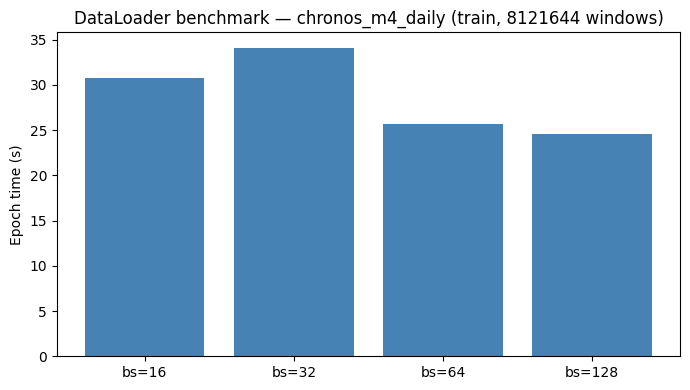

In [7]:
def time_one_epoch(dataset, batch_size: int, workers: int = 0) -> float:
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                        num_workers=workers, drop_last=True)
    t0 = time.perf_counter()
    for batch in loader:
        _ = batch["past_values"], batch["future_values"]
    return time.perf_counter() - t0

configs = [
    (16,  0),
    (32,  0),
    (64,  0),
    (128, 0),
]

print(f"{'batch_size':>12}  {'workers':>8}  {'time (s)':>10}  {'windows/s':>12}")
print("-" * 50)
results = []
for bs, wk in configs:
    t = time_one_epoch(train_ds, bs, wk)
    wps = len(train_ds) / t
    results.append((bs, wk, t, wps))
    print(f"{bs:>12}  {wk:>8}  {t:>10.3f}  {wps:>12,.0f}")

# Bar chart
fig, ax = plt.subplots(figsize=(7, 4))
labels = [f"bs={r[0]}" for r in results]
ax.bar(labels, [r[2] for r in results], color="steelblue")
ax.set_ylabel("Epoch time (s)")
ax.set_title(f"DataLoader benchmark — {DATASET_NAME} (train, {len(train_ds)} windows)")
plt.tight_layout()
plt.show()

## 8. Visualise Sample Windows

C:\Users\User\AppData\Local\Temp\ipykernel_24412\1487300255.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


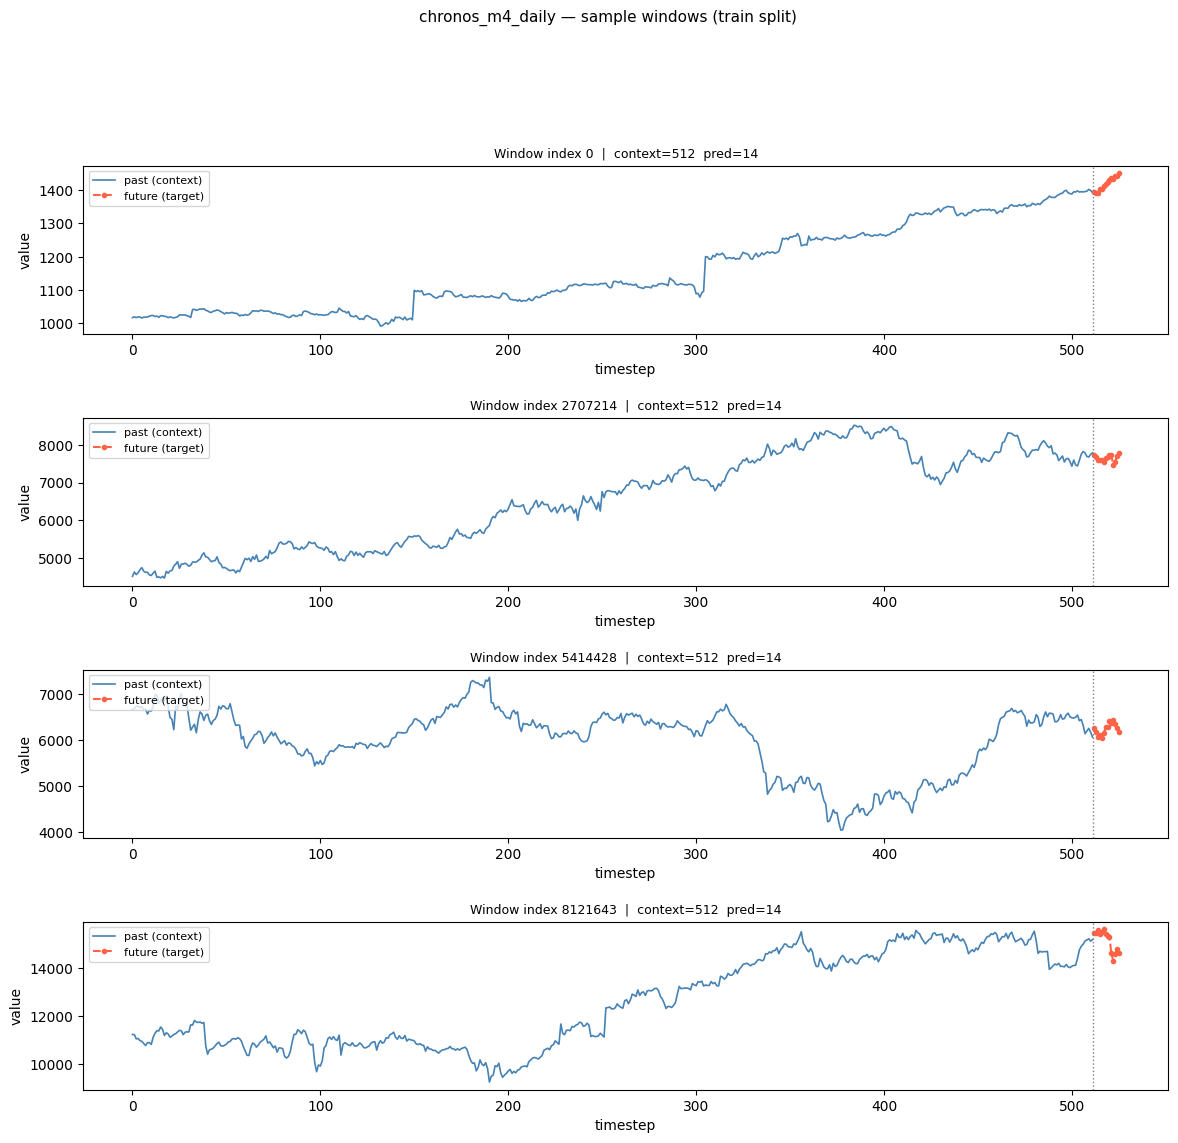

In [8]:
N_PLOT = 4  # number of windows to visualise

fig = plt.figure(figsize=(14, 3 * N_PLOT))
gs  = gridspec.GridSpec(N_PLOT, 1, hspace=0.5)

# Sample N_PLOT windows spread evenly through the training set
indices = np.linspace(0, len(train_ds) - 1, N_PLOT, dtype=int)

for row, idx in enumerate(indices):
    sample = train_ds[int(idx)]
    past   = sample["past_values"].numpy()
    future = sample["future_values"].numpy()

    ax = fig.add_subplot(gs[row])
    x_past   = np.arange(len(past))
    x_future = np.arange(len(past), len(past) + len(future))

    ax.plot(x_past,   past,   color="steelblue", linewidth=1.2, label="past (context)")
    ax.plot(x_future, future, color="tomato",    linewidth=1.5,
            linestyle="--", marker="o", markersize=3, label="future (target)")
    ax.axvline(len(past) - 1, color="grey", linestyle=":", linewidth=1)
    ax.set_title(f"Window index {idx}  |  context={len(past)}  pred={len(future)}", fontsize=9)
    ax.legend(fontsize=8, loc="upper left")
    ax.set_xlabel("timestep")
    ax.set_ylabel("value")

plt.suptitle(f"{DATASET_NAME} — sample windows (train split)", y=1.01, fontsize=11)
plt.tight_layout()
plt.show()